<a href="https://colab.research.google.com/github/kgoldra/capstone_Xplisit/blob/main/nailornot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import zipfile
import os
import shutil
import random
from shutil import copyfile
import cv2
import numpy as np
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import RMSprop

In [2]:
try:
  shutil.rmtree('/content/nailornot')
  shutil.rmtree('/content/Data')
  shutil.rmtree('/content/test')
except:
  pass

In [3]:
path_nails = f"/content/nailornot.zip"

local_zip = path_nails
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [4]:
ORIGINDIR = "/content/nailornot"
DATADIR = "/content/Data"
TRAINORTEST = ["training", "testing"]
CATEGORIES = ["nails","notnails"]

In [5]:
counter = 0

for trainortest in TRAINORTEST:
  path = os.path.join(DATADIR, trainortest)
  for category in CATEGORIES:
    counter += 1
    originpath = os.path.join(ORIGINDIR, category)
    path2 = os.path.join(path, category)
    if(counter) <= 2:
      print(category, "Datasets Has: ", len(os.listdir(originpath)) ,"Data")
    os.makedirs(path2)
    pass

nails Datasets Has:  840 Data
notnails Datasets Has:  769 Data


In [6]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
    
    training_sets = int(len(files) * SPLIT_SIZE)
    testing_sets = int(len(files) - training_sets)
    randomed = random.sample(files,len(files))
    training_files = randomed[0:training_sets]
    testing_files = randomed[:testing_sets]
    
    for filename in training_files:
        source = SOURCE + filename
        destination = TRAINING + filename
        copyfile(source, destination)
        
    for filename in testing_files:
        source = SOURCE + filename
        destination = TESTING + filename
        copyfile(source, destination)

In [7]:
nails_DIR = "/content/nailornot/nails/"
TRAINING_nails_DIR = "/content/Data/training/nails/"
TESTING_nails_DIR = "/content/Data/testing/nails/"

notnails_DIR = "/content/nailornot/notnails/"
TRAINING_notnails_DIR = "/content/Data/training/notnails/"
TESTING_notnails_DIR = "/content/Data/testing/notnails/"


split_size = .9




split_data(nails_DIR, TRAINING_nails_DIR, TESTING_nails_DIR, split_size)
split_data(notnails_DIR, TRAINING_notnails_DIR, TESTING_notnails_DIR, split_size)

In [8]:
IMGSIZE = 256

In [9]:
training_data = []

def create_training_data():
  path = os.path.join(DATADIR, "training")
  for category in CATEGORIES:
    path2 = os.path.join(path, category)
    class_label = CATEGORIES.index(category)
    for img in os.listdir(path2):
      img_array = cv2.imread(os.path.join(path2,img))
      new_array = cv2.resize(img_array, (IMGSIZE, IMGSIZE))
      training_data.append([new_array, class_label])

create_training_data()

In [10]:
testing_data = []

def create_testing_data():
  path = os.path.join(DATADIR, "testing")
  for category in CATEGORIES:
    path2 = os.path.join(path, category)
    class_label = CATEGORIES.index(category)
    for img in os.listdir(path2):
      img_array = cv2.imread(os.path.join(path2,img))
      new_array = cv2.resize(img_array, (IMGSIZE, IMGSIZE))
      testing_data.append([new_array, class_label])

create_testing_data()

In [11]:
X = []
x_label = []
y = []
y_label = []

for features, label in training_data:
  X.append(features)
  x_label.append(label)

  
for features, label in testing_data:
  y.append(features)
  y_label.append(label)

In [12]:
X = tf.keras.utils.normalize(X, axis = 1)
y = tf.keras.utils.normalize(y, axis = 1)
x_label = np.array(x_label).astype('float')
y_label = np.array(y_label).astype('float')

print(X.shape)
print(y.shape)
print(x_label.shape)
print(y_label.shape)

(1448, 256, 256, 3)
(161, 256, 256, 3)
(1448,)
(161,)


In [13]:
training_datagen = ImageDataGenerator(
      rescale = 1.0/255.,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')


validation_datagen = ImageDataGenerator(
    rescale = 1./255.,
)

In [14]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape= (IMGSIZE,IMGSIZE,3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
train_generator = training_datagen.flow(
    X,
    x_label,
    batch_size = 32
)

validation_generator = validation_datagen.flow(
    y,
    y_label,
    batch_size = 32
)

In [16]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>=90):
                print("\nReached 90% Accuracy so cancelling training!")
                self.model.stop_training = True

In [17]:
from keras.optimizers import SGD
callbacks=myCallback()
opt = RMSprop(lr=0.01)

model.summary()

model.compile(loss = 'binary_crossentropy', optimizer= opt, metrics=['accuracy'])


history = model.fit(
    train_generator,
    steps_per_epoch = 1448/64,
    validation_data = validation_generator,
    validation_steps = 161/64,
    epochs = 2, callbacks = [callbacks]
)


model.save('model.h5')
files.download('model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

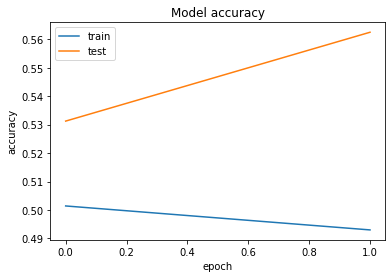

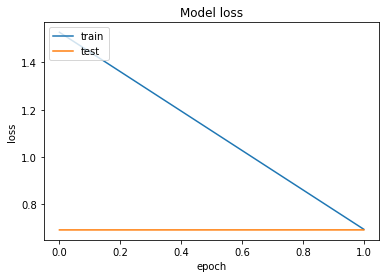

In [18]:
def plot_train_history(history1):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_train_history(history)

In [19]:
test_label = [0,1]
class_names = CATEGORIES

In [20]:
path_test = f"/content/test.zip"

local_zip = path_test
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [26]:
files = []
SOURCE = '/content/test/'
for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if os.path.getsize(file) > 0:
        files.append(filename)
    else:
        print(filename + " is zero length, so ignoring.")

00000020.jpg


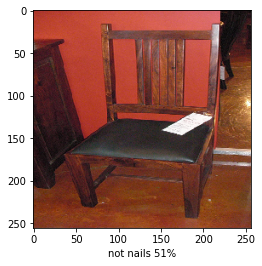

00000019.jpg


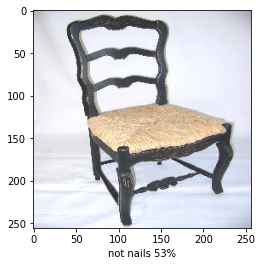

10-193.jpg


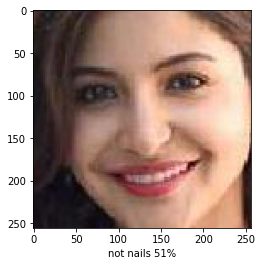

00000021.jpg


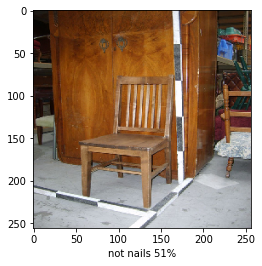

10-366.jpg


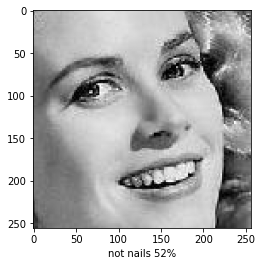

00000022.jpg


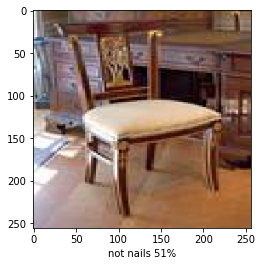

10-295.jpg


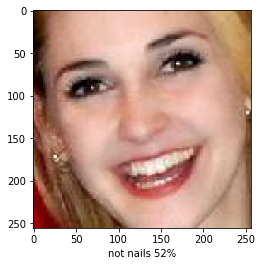

9-630.jpg


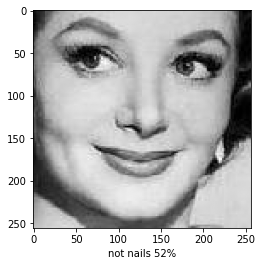

00000018.jpg


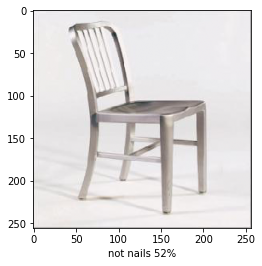

00000015.jpg


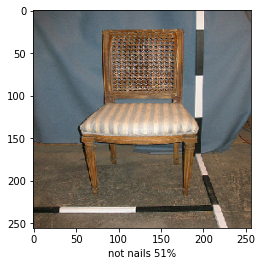

9-526.jpg


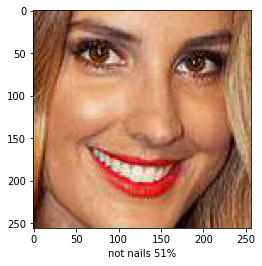

10-140.jpg


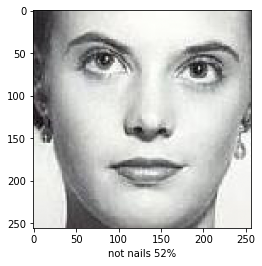

10-274.jpg


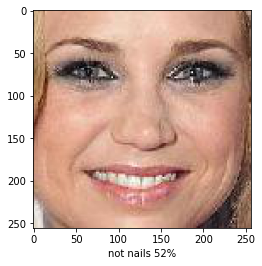

00000028.jpg


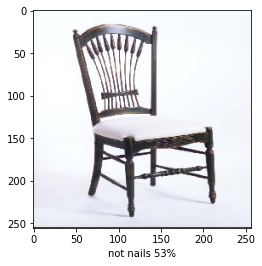

00000031.jpg


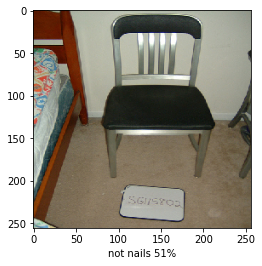

10-226.jpg


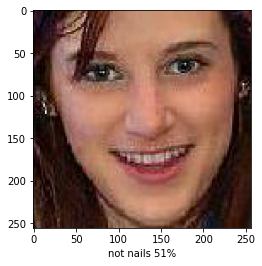

10-032.jpg


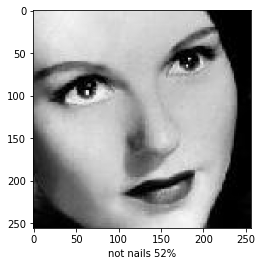

00000014.jpg


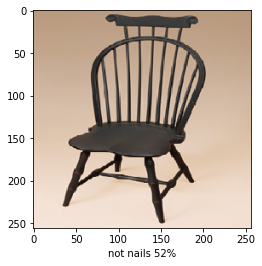

10-425.jpg


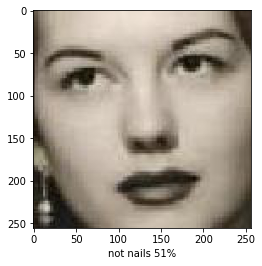

10-558.jpg


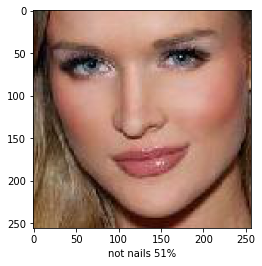

00000017.jpg


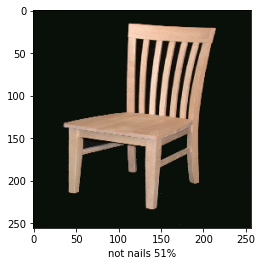

00000030.jpg


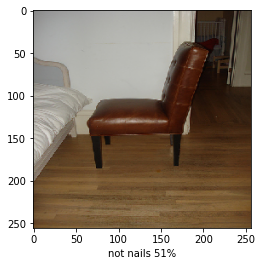

10-380.jpg


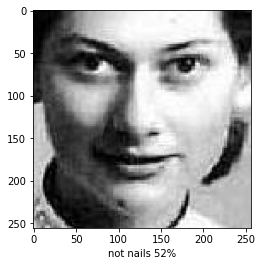

00000026.jpg


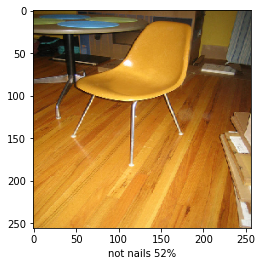

9-556.jpg


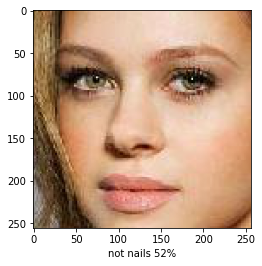

00000013.jpg


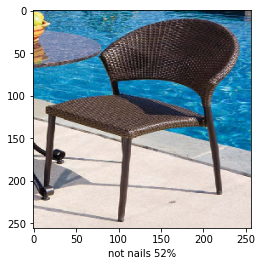

10-487.jpg


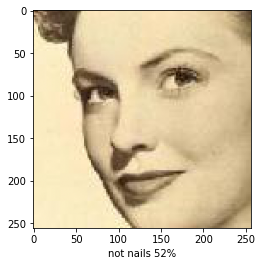

00000023.jpg


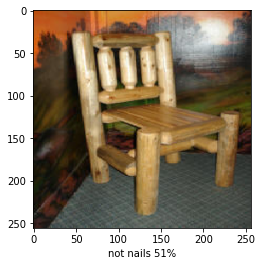

00000032.jpg


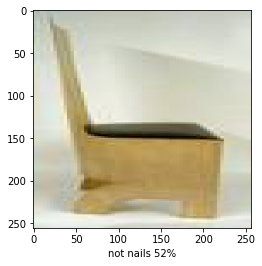

00000012.jpg


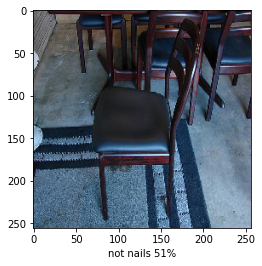

00000029.jpg


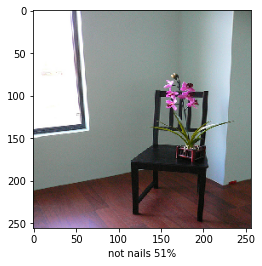

00000025.jpg


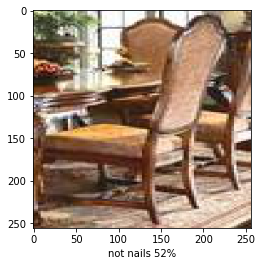

00000027.jpg


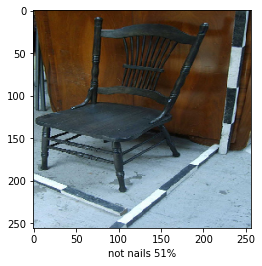

00000024.jpg


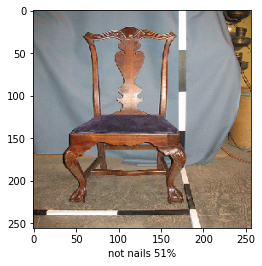

10-513.jpg


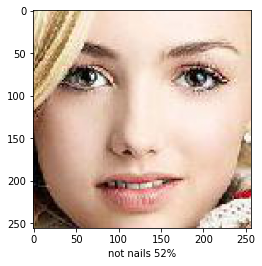

00000016.jpg


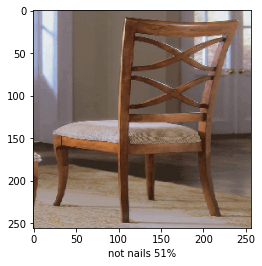

10-230.jpg


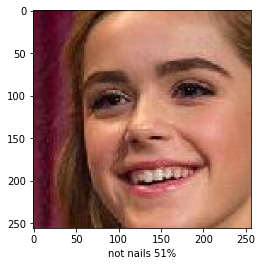

00000033.jpg


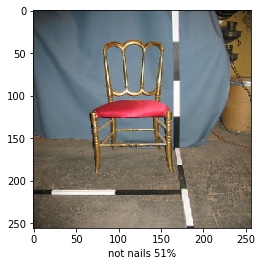

100.0% correct


In [27]:
count = 0
count2 = 0
for file in files:
  count += 1
  path = SOURCE + file
  img = image.load_img(path, target_size=(IMGSIZE, IMGSIZE))
  img = np.array(img)
  img = img/255.
  xy = img
  xy = np.expand_dims(img, axis=0)
  images = np.vstack([xy])
  predictions = model.predict(images, batch_size=32)


  print(file)
  imgplot = plt.imshow(img)
  if(predictions >= 0.5):
    plt.xlabel("{} {:2.0f}%".format("nails",
                             100*np.max(predictions)))
  else:
    plt.xlabel("{} {:2.0f}%".format("not nails",
                             100*(1-np.max(predictions))))
    count2 += 1

  plt.show()

print("{}% correct".format(count2/count*100))

In [23]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

Saving test 1.jpg to test 1.jpg


00000033.jpg


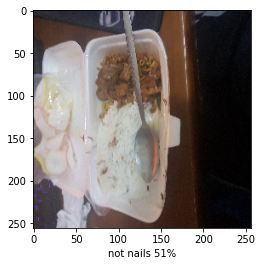

In [28]:
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(IMGSIZE, IMGSIZE))
  img = np.array(img)
  img = img/255.
  xy = img
  xy = np.expand_dims(img, axis=0)
  images = np.vstack([xy])
  predictions = model.predict(images, batch_size=32)

  print(file)
  imgplot = plt.imshow(img)
  if(predictions >= 0.5):
    plt.xlabel("{} {:2.0f}%".format("nails",
                             100*np.max(predictions)))
  else:
    plt.xlabel("{} {:2.0f}%".format("not nails",
                             100*(1-np.max(predictions))))

  plt.show()

In [29]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

model.save_weights("model.h5")